# Build an agent with tool-calling superpowers 🦸 using Transformers Agents

What are **agents?** Agents are systems that are powered by an LLM and enable the LLM (with careful prompting and output parsing) to use specific tools to solve problems.

These tools are basically functions that the LLM couldn’t perform well by itself: for instance for a text-generation LLM like **Llama-3-70B**, this could be an image generation tool, a web search tool, a calculator…

What is **Transformers Agents**? it’s an extension of our ***transformers*** library that provides building blocks to build your own agents! Learn more about it in the documentation.

## 1. 🏞️ Multimodal + 🌐 Web-browsing assistant

You're loading a tool from the Hub from None. Please make sure this is a source that you trust as the code within that tool will be executed on your machine. Always verify the code of the tools that you load. We recommend specifying a `revision` to ensure you're loading the code that you have checked.
TextToImageTool implements a different description in its configuration and class. Using the tool configuration description.
======== New task ========
Generate me a photo of hedgehog with cactus designed hat
=== Agent thoughts:
Thought: I will use the `image_generator` tool to generate an image of a hedgehog wearing a cactus designed hat.
>>> Agent is executing the code below:
image = image_generator(prompt="A hedgehog wearing a cactus designed hat")
final_answer(image)
====
Print outputs:

Last output from code snippet:
C:\Users\furka\AppData\Local\Temp\tmpzh4itijn\1c93795b-edad-4721-86dc-16e39c8821ca.png
Final answer:
C:\Users\furka\AppData\Local\Temp\tmpzh4itijn\1c93795b-edad-4721-86d

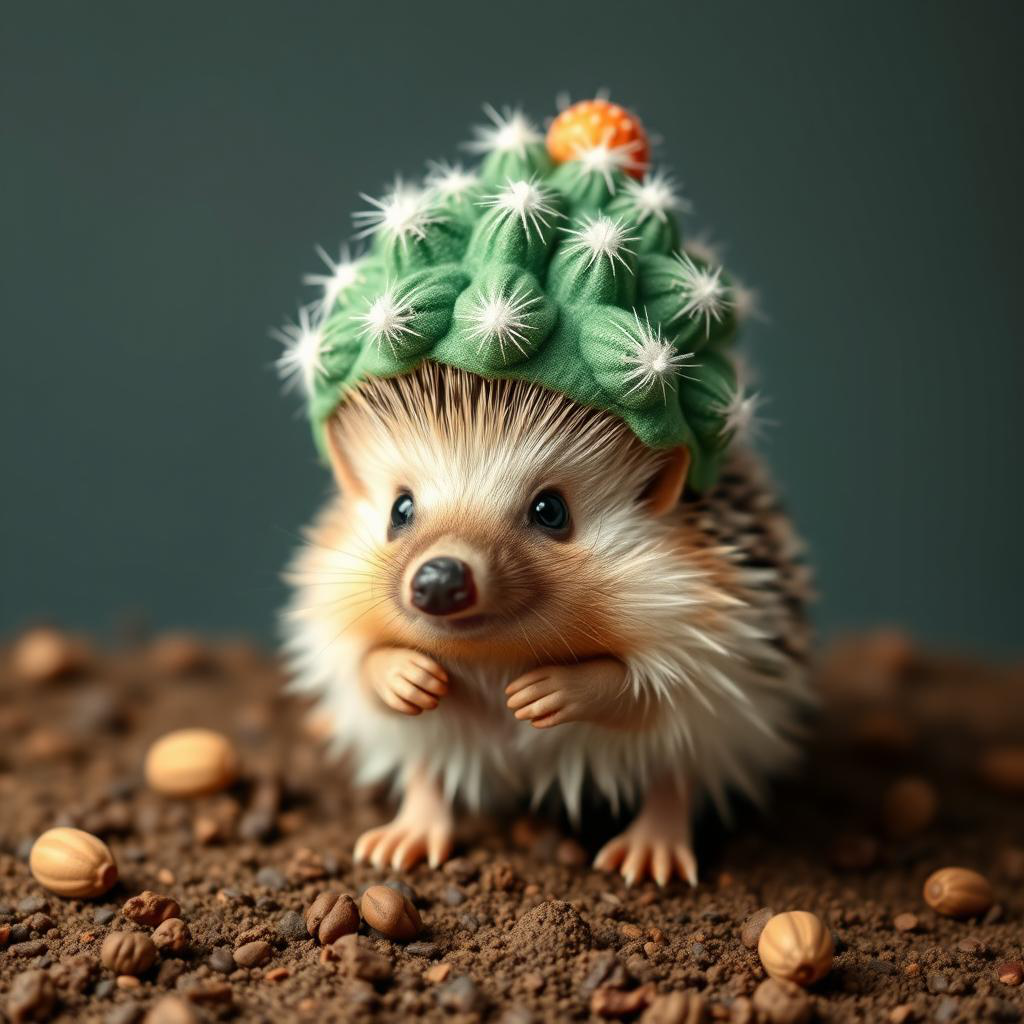

In [1]:
from transformers import load_tool, ReactCodeAgent, HfApiEngine

# Import tool from Hub
image_generation_tool = load_tool("m-ric/text-to-image", cache=False)

# Import tool from LangChain
from transformers.agents.search import DuckDuckGoSearchTool

search_tool = DuckDuckGoSearchTool()

llm_engine = HfApiEngine("Qwen/Qwen2.5-72B-Instruct")
# Initialize the agent with both tools
agent = ReactCodeAgent(tools=[image_generation_tool, search_tool], llm_engine=llm_engine)

# Run it!
result = agent.run(
    "Generate me a photo of hedgehog with cactus designed hat",
)
result

## 2. 📚💬 RAG with Iterative query refinement & Source selection

**Quick definition:** Retrieval-Augmented-Generation (RAG) is “using an LLM to answer a user query, but basing the answer on information retrieved from a knowledge base”.

This method has many advantages over using a vanilla or fine-tuned LLM: to name a few, it allows to ground the answer on true facts and reduce confabulations, it allows to provide the LLM with domain-specific knowledge, and it allows fine-grained control of access to information from the knowledge base.

    -Now let’s say we want to perform RAG, but with the additional constraint that some parameters must be dynamically generated. For example, depending on the user query we could want to restrict the search to specific subsets of the knowledge base, or we could want to adjust the number of documents retrieved. The difficulty is: how to dynamically adjust these parameters based on the user query?

    -A frequent failure case of RAG is when the retrieval based on the user query does not return any relevant supporting documents. Is there a way to iterate by re-calling the retriever with a modified query in case the previous results were not relevant?

🔧 Well, we can solve the points above in a simple way: we will give our agent control over the retriever’s parameters!

In [3]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [4]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]}) for doc in knowledge_base
]

docs_processed = RecursiveCharacterTextSplitter(chunk_size=500).split_documents(source_docs)[:1000]

embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
vectordb = FAISS.from_documents(documents=docs_processed, embedding=embedding_model)

C:\Users\furka\AppData\Local\Temp\ipykernel_1604\776685767.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")


Now that we have the database ready, let’s build a RAG system that answers user queries based on it!

We want our system to select only from the most relevant sources of information, depending on the query.

Our documentation pages come from the following sources:

In [5]:
all_sources = list(set([doc.metadata["source"] for doc in docs_processed]))
print(all_sources)

['course', 'diffusers', 'hf-endpoints-documentation', 'pytorch-image-models', 'datasets-server', 'peft', 'deep-rl-class', 'transformers', 'hub-docs', 'datasets', 'evaluate', 'optimum', 'gradio', 'blog']


👉Now let’s build a RetrieverTool that our agent can leverage to retrieve information from the knowledge base.

Since we need to add a vectordb as an attribute of the tool, we cannot simply use the simple tool constructor with a @tool decorator: so we will follow the advanced setup highlighted in the advanced agents documentation.

In [6]:
import json
from transformers.agents import Tool
from langchain_core.vectorstores import VectorStore


class RetrieverTool(Tool):
    name = "retriever"
    description = (
        "Retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    )
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        },
        "source": {"type": "string", "description": ""},
        "number_of_documents": {
            "type": "string",
            "description": "the number of documents to retrieve. Stay under 10 to avoid drowning in docs",
        },
    }
    output_type = "string"

    def __init__(self, vectordb: VectorStore, all_sources: str, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb
        self.inputs["source"]["description"] = (
            f"The source of the documents to search, as a str representation of a list. Possible values in the list are: {all_sources}. If this argument is not provided, all sources will be searched.".replace(
                "'", "`"
            )
        )

    def forward(self, query: str, source: str = None, number_of_documents=7) -> str:
        assert isinstance(query, str), "Your search query must be a string"
        number_of_documents = int(number_of_documents)

        if source:
            if isinstance(source, str) and "[" not in str(source):  # if the source is not representing a list
                source = [source]
            source = json.loads(str(source).replace("'", '"'))

        docs = self.vectordb.similarity_search(
            query,
            filter=({"source": source} if source else None),
            k=number_of_documents,
        )

        if len(docs) == 0:
            return "No documents found with this filtering. Try removing the source filter."
        return "Retrieved documents:\n\n" + "\n===Document===\n".join([doc.page_content for doc in docs])

### Run the Agent!

from transformers.agents import HfApiEngine, ReactJsonAgent

llm_engine = HfApiEngine("Qwen/Qwen2.5-72B-Instruct")

retriever_tool = RetrieverTool(vectordb=vectordb, all_sources=all_sources)
agent = ReactJsonAgent(tools=[retriever_tool], llm_engine=llm_engine, verbose=0)

agent_output = agent.run("Please show me a LORA finetuning script")

print("Final output:")
print(agent_output)

## 3. 💻 Debug Python code

In [9]:
from transformers import ReactCodeAgent

agent = ReactCodeAgent(tools=[], llm_engine=HfApiEngine("Qwen/Qwen2.5-72B-Instruct"))

code = """
list=[0, 1, 2]

for i in range(4):
    print(list(i))
"""

final_answer = agent.run(
    "I have some code that creates a bug: please debug it, then run it to make sure it works and return the final code",
    code=code,
)

======== New task ========
I have some code that creates a bug: please debug it, then run it to make sure it works and return the final code
You have been provided with these initial arguments: {'code': '\nlist=[0, 1, 2]\n\nfor i in range(4):\n    print(list(i))\n'}.
=== Agent thoughts:
Thought: I will start by identifying the issue in the code. The error seems to be related to the incorrect use of `list(i)` inside the for loop. Since `list` is a Python built-in name, using it as a variable can cause issues. I will change the variable name and make sure to properly access the elements of the list. I will also fix the for loop range, as the list only has three elements.
>>> Agent is executing the code below:
# Correcting the variable name and accessing elements properly
my_list = [0, 1, 2]

for i in range(len(my_list)):
    print(my_list[i])

# Returning the corrected code
corrected_code = '\nmy_list = [0, 1, 2]\n\nfor i in range(len(my_list)):\n    print(my_list[i])\n'
final_answer(cor

In [10]:
print(final_answer)


my_list = [0, 1, 2]

for i in range(len(my_list)):
    print(my_list[i])



## 4. Create your own LLM engine (OpenAI)

It’s really easy to set up your own LLM engine: it only needs a __call__ method with these criteria:

1. Takes as input a list of messages in ChatML format and outputs the answer.
2. Accepts a stop_sequences arguments to pass sequences on which generation stops.
3. Depending on which kind of message roles your LLM accepts, you may also need to convert some message roles.

In [11]:
import os
from openai import OpenAI
from transformers.agents.llm_engine import MessageRole, get_clean_message_list

openai_role_conversions = {
    MessageRole.TOOL_RESPONSE: "user",
}


class OpenAIEngine:
    def __init__(self, model_name="gpt-4o-2024-05-13"):
        self.model_name = model_name
        self.client = OpenAI(
            api_key=os.getenv("OPENAI_API_KEY"),
        )

    def __call__(self, messages, stop_sequences=[]):
        # Get clean message list
        messages = get_clean_message_list(messages, role_conversions=openai_role_conversions)

        # Get LLM output
        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=messages,
            stop=stop_sequences,
        )
        return response.choices[0].message.content


openai_engine = OpenAIEngine()
agent = ReactCodeAgent(llm_engine=openai_engine, tools=[])

code = """
list=[0, 1, 2]

for i in range(4):
    print(list(i))
"""

final_answer = agent.run(
    "I have some code that creates a bug: please debug it and return the final code",
    code=code,
)
print(final_answer)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable